In [65]:
from graphviz import Graph, Digraph
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt



import numpy as np
import sys
from pathlib import Path

# Add the parent directory of the notebook to sys.path
parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))

from utils.load import load_feature_matrices, load_metadata
from scripts.features import save_ctms, save_sequences
from utils.frobenius import create_frobenius_adjacency_matrix
from models.graph import create_movie_nodes, MovieGraph
from utils.metrics import create_kl_adjacency


In [66]:
# 1. Create your NetworkX graph (any graph you want)
G = nx.Graph()
G.add_edges_from([(1,2), (1,3), (1,4), (2,5), (3,5), (4,5), (5,6), (5,7), (6,7)])

# 2. Convert to Graphviz the easy way (no pygraphviz needed)
dot = Graph(comment="My beautiful graph", strict=True)
dot.attr(rankdir="TB")              # optional: TB = top-to-bottom, LR = left-to-right
dot.attr("node", shape="ellipse", style="filled", fillcolor="lightblue", fontname="Arial")

for node in G.nodes():
    dot.node(str(node))

for u, v in G.edges():
    dot.edge(str(u), str(v))

# 3. Render — creates a perfect PDF/SVG/PNG instantly
dot.render("my_graph", format="png", cleanup=True)   # creates my_graph.pdf
# dot.render("my_graph", format="svg", cleanup=True) # or SVG
# dot.render("my_graph", format="png", cleanup=True) # or PNG

print("Graph saved as my_graph.pdf — open it!")

Graph saved as my_graph.pdf — open it!


In [67]:
matrices_df = load_feature_matrices("../data/ctms")
metadata_df = load_metadata("../data/metadata/movies_metadata.csv")

# Normalize each CTM so the total sum is 1
def normalize_rowwise(M: np.ndarray) -> np.ndarray:
    M = M.astype(np.float64)          # convert to float
    row_sums = M.sum(axis=1, keepdims=True)
    return np.divide(M, row_sums, out=np.zeros_like(M), where=row_sums!=0)

matrices_df['matrix'] = matrices_df['matrix'].apply(normalize_rowwise)

metadata_df = metadata_df.loc[matrices_df.index] # align matrices and metadata

Loading matrices: 91it [00:00, 1518.87it/s]
2025-11-25 05:11:22.331 | SUCCESS  | utils.load:load_feature_matrices:45 - Loaded 91 matrices from ../data/ctms


In [68]:
ctms_list = matrices_df['matrix'].tolist()
kl_matrix = create_kl_adjacency(ctms_list)

Computing KL adjacency (unmasked): 100%|██████████| 91/91 [00:01<00:00, 76.44it/s]


In [69]:
nodes = create_movie_nodes(metadata_df)
graph = MovieGraph(nodes, kl_matrix)

In [70]:
threshold = np.percentile(kl_matrix[np.triu_indices_from(kl_matrix, 1)], 75)

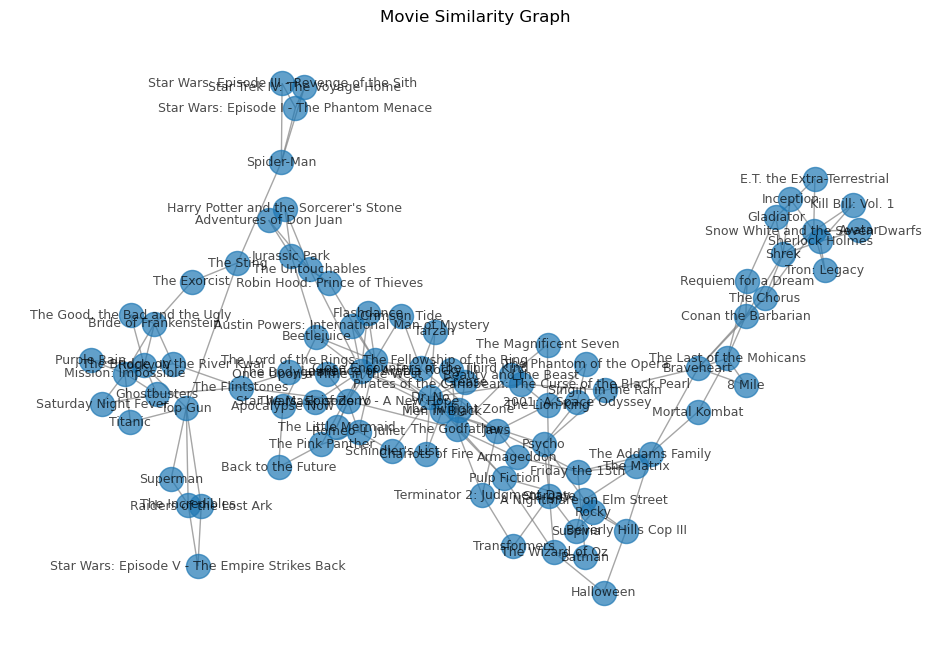

In [71]:
graph.plot_graph_networkx(kl_matrix, k=2, threshold=threshold, layout="spring")

Graphviz visualization

In [ ]:

# Some default clustering
nodes = np.arange(91)  
cluster_labels = nodes % 3
cluster_colors = ['#ff1493', '#39FF14', '#0088ff']

adj = kl_matrix

n = adj.shape[0]

weights = adj[adj > 0]
if len(weights) == 0:
    weights = np.array([1])
min_w, max_w = weights.min(), weights.max()


dot = Graph('100_nodes', engine='sfdp')       
# dot.attr('node', shape='circle', style='filled', 
#          fillcolor='lightblue', width='0.5', height='0.5', fixedsize='true', z='1')
# dot.attr('edge', penwidth='0.8', color='#555555', z='0')
dot.attr(outputorder='edgesfirst')
dot.attr(overlap='voronoi')

dot.attr('node',
         shape='circle',
         style='filled',
         fillcolor='#ff1493',     
         color='#ff69b4',         
         penwidth='0',             
         width='0.1',
         height='0.1',
         fixedsize='true',
         margin='0',              
         fontsize='0',            
         label='',                
         fontcolor='none',        
         z='100')


# dot.attr(splines='curved')
dot.attr(splines='polyline')
dot.attr(overlap='prism1000')                 # optional but helps a lot with curved edges
dot.attr(esep='1.0')


dot.attr('graph', sep='0')
dot.attr(nodesep='2.0')     # horizontal distance between nodes
dot.attr(ranksep='3.0')    
dot.attr(sep='+5')         # global “push-out” force 
# dot.attr(esep='1.5')



for i in range(n):
    dot.node(str(i))

for i in range(n):
    for j in range(i+1, n):      

        # edges 

        w = adj[i, j]
        if w > 0:
            # Normalize weights
            normalized = (w - min_w) / (max_w - min_w) if max_w > min_w else 1.0

            # Opacity: 30% -> 100%, if we want to change the opacity depending on distance
            alpha = int(0.3 + 0.7 * normalized * 255)     # 77 → 255 in hex
            opacity_hex = f"{alpha:02X}"

            # Thickness of the edge, between 0.8 - 4.0, in this case
            penwidth = 0.8 + 3.2 * normalized

            distance = 0.1 + 10.0 * (1 - normalized)**10

            # Color with opacity
            color = f"#ff69b4{opacity_hex}"

            if w<700:
                dot.edge(str(i), str(j),
                        #  penwidth=f"{penwidth:.2f}",
                        penwidth="0.3",
                        color=color)
                
            # We just hide for now the edges outside of this range

            # else:
            #     dot.edge(str(i), str(j),
            #             #  penwidth=f"{penwidth:.2f}",
            #             penwidth="1.5",
            #             color="#444444",
            #             len=f"{distance:.3f}")


        # nodes

        cluster_clr = cluster_colors[cluster_labels[i]]

        if cluster_labels[i]==cluster_labels[j]:
            dot.node(str(i),
                 fillcolor=cluster_clr,
                 color=cluster_clr,
                 penwidth='0')
            
            dot.node(str(j),
                 fillcolor=cluster_clr,
                 color=cluster_clr,
                 penwidth='0')
            
            dot.edge(str(i), str(j),
                        #  penwidth=f"{penwidth:.2f}",
                        penwidth="0.3",
                        color=cluster_clr)


# save svg
# dot.render('100_nodes_fast', format='svg', cleanup=True)

lib/pathplan/shortest.c:180: source point not in any triangle
lib/pathplan/shortest.c:191: destination point not in any triangle
lib/pathplan/shortest.c:191: destination point not in any triangle
lib/pathplan/shortest.c:191: destination point not in any triangle
lib/pathplan/shortest.c:180: source point not in any triangle
lib/pathplan/shortest.c:180: source point not in any triangle
lib/pathplan/shortest.c:191: destination point not in any triangle
lib/pathplan/shortest.c:180: source point not in any triangle
lib/pathplan/shortest.c:191: destination point not in any triangle
lib/pathplan/shortest.c:180: source point not in any triangle
lib/pathplan/shortest.c:191: destination point not in any triangle
lib/pathplan/shortest.c:191: destination point not in any triangle
lib/pathplan/shortest.c:191: destination point not in any triangle
lib/pathplan/shortest.c:180: source point not in any triangle
lib/pathplan/shortest.c:191: destination point not in any triangle
lib/pathplan/shortest.c:1

'100_nodes_fast.svg'